# Assignment 3: Predictive analysis - Part 1: Linear Regression
## Group 105
- Natasa Bolic (300241734)
- Brent Palmer (300193610)
## Imports

In [264]:
# imports
import pandas as pd
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
import numpy as np

## Introduction

## Dataset Description

**Url:** https://www.kaggle.com/datasets/nehalbirla/vehicle-dataset-from-cardekho <br>
**Name:** Vehicle Dataset <br>
**Author:** The author is not provided. However, the data is scraped from CarDekho, which is an online platform for selling and buying used cars in India. <br>
**Purpose:** The dataset consists of features of used cars. One purpose of the dataset is to allow users to practice linear regression to predict car prices, as described on Kaggle. However, it does not appear that the dataset has one original purpose, it can be used for many car-related applications. <br>
**Shape:** There are 4340 rows and 8 columns. (4340, 8)<br>
**Features:**
- `name` (categorical): The name of the car, including the car brand and the model name and variants.
- `year` (numerical): The year that the car was manufactured.
- `selling_price` (numerical): The price of the car.
- `km_driven` (numerical): The number of kilometres that the car has been driven.
- `fuel` (categorical): The fuel type of the car, which can be petrol, diesel, CNG, LPG or electric.
- `seller_type` (categorical): The type of the seller, which can be either an individual or a dealer.
- `transmission` (categorical): The car's gear transmission, which can be either automatic or manual.
- `owner` (categorical): The number of individuals that have previously owned the car.

Note: we have already used a dataset in the same domain (cars) in a previous assignment, but this is a different dataset with different features.

## Loading Data and Basic Exploration

In [229]:
# Read in the dataset from a public repository
url = "https://raw.githubusercontent.com/Natasa127/CSI4142-A3/refs/heads/main/Dekho-Car-Details.csv"
car_df = pd.read_csv(url)
car_df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner


In [230]:
car_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name           4340 non-null   object
 1   year           4340 non-null   int64 
 2   selling_price  4340 non-null   int64 
 3   km_driven      4340 non-null   int64 
 4   fuel           4340 non-null   object
 5   seller_type    4340 non-null   object
 6   transmission   4340 non-null   object
 7   owner          4340 non-null   object
dtypes: int64(3), object(5)
memory usage: 271.4+ KB


In [231]:
car_df.shape

(4340, 8)

## Regression Empirical Study

### (a) Cleaning the data

In this section, we will use the validity checks from `Assignment 2` to identify any invalid data. If needed, an imputation method may be used to clean the data. Note that we will be doing each of the ten validity checks, although they might be in a different order than in assignment 2. They will be clearly enumerated. Furthermore, in `Assignment 2`, we saved a copy of the invalid rows in our validity checks. In this assignment, we will first check the count of invalid rows; if there are none, we will omit the code that saves a copy, and displays invalid rows. If we find the error count to be non-zero, we will then clean it instead in addition to displaying some of the invalid values.

#### Validity Check 1: Exact Duplicates

We first check for exact duplicates in the car dataset. This check verifies whether there are rows that are identical over all columns.

**References:** <br>
Exact Duplicates: https://uottawa.brightspace.com/d2l/le/content/490358/viewContent/6620388/View (Slide 27)

In [232]:
# Exact duplicates check

# Apply the .duplicated method to the DataFrame to create a Series, with exact duplicates set to True
duplicates = car_df.duplicated()

# Print the number of rows that are exact duplicates
print(f"Number of duplicate rows: {duplicates.sum()}")

Number of duplicate rows: 763


There are 763 exact duplicate rows, so we look into the actual rows to determine how to handle them.

In [233]:
# Save the invalid rows
invalid_exact_duplicate_df = car_df.loc[duplicates]

# Display the first 3 rows that are exact duplicates
print("Examples of three exact duplicate rows:")
invalid_exact_duplicate_df.head(3)

Examples of three exact duplicate rows:


,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
13,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
14,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
15,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner


It makes sense that the rows have some attributes in common, such as cars with the same name having the same transmission. However, it is unlikely that two cars have exactly the same attributes, particularly due to the attribute `km_driven`, which depends greatly on the owners of the car (an attribute which is not recorded).

A common tactic for sellers on online market platforms, like CarDekho, is to relist their product so that their listing appears newer and higher up in the page. So, we believe that these duplicates are likely due to multiple listings of the same cars. Since it is likely that the duplicated entries represent the same car, we believe it is justified to keep one of the duplicates and remove the rest. In other words, we handle the exact duplicates using listwise removal.

In addition, we note that the number of entries deleted does not make up a very large proportion of the data, so we can delete the instances without worrying about compromising the quality of the rest of our analysis (there are still 3577 instances).

In [234]:
# Select the all the entries that were not duplicated, and the first instance of every duplicated entry
cleaned_car_df = car_df.loc[~duplicates]
# Print the number of valid entries remaining
print(f"Number of rows after removing duplicates: {len(cleaned_car_df)}")

Number of rows after removing duplicates: 3577


#### Validity Check 2: Format errors

None of the features in this dataset have a specific format to be verified, so the format check does not apply here. Note that we could check that `year` is in the correct format, but since it is stored as an `integer` (and not a `datetime` object), we decide to check its validity through the datatype and range checks instead.

#### Validity Check 3: Uniqueness errors

None of the features in this dataset are intended to be unique, so the uniqueness check does not apply here.

#### Validity Check 4: Presence errors

We will use the presence check from `Assignment 2` to verify whether there is missing data in any of the columns. Minimal changes are necessary to the code; instead of taking a parameter input, we will simply iterate over all of the columns to determine if any of them have missing values. We also added a check for strings of whitespace, which we qualify as a missing value as well.

In [235]:
# Presence check

# Iterate over each column and perform the presence check on each
for column in cleaned_car_df:
    # Apply pd.isna() to the test attribute, or check if it is a string of whitespace, setting rows with missing values in the designated column to True
    invalid_presence = cleaned_car_df[column].apply(lambda attribute: (pd.isna(attribute) or (isinstance(attribute, str) and attribute.strip() == "")))

    # Print the number of rows with a missing value in the chosen test attribute
    print(f"Number of rows where the {column} value is missing: {invalid_presence.sum()}")

Number of rows where the name value is missing: 0
Number of rows where the year value is missing: 0
Number of rows where the selling_price value is missing: 0
Number of rows where the km_driven value is missing: 0
Number of rows where the fuel value is missing: 0
Number of rows where the seller_type value is missing: 0
Number of rows where the transmission value is missing: 0
Number of rows where the owner value is missing: 0


Since there are no missing values in any of the columns, no cleaning is required.

#### Validity Check 5: Length errors

None of the features in this dataset are intended to be a specific length, so the length check does not apply here.

#### Validity Check 6: Look-up errors

We will use the look-up check from `Assignment 2` to validate that the column values exist in a pre-defined finite set of values, if applicable. Minimal changes are necessary to the code from the previous assignment; we define a dictionary containing all of the relevant features along with their look-up tables. Then, we iterate over all of these features and apply the procedure from the previous assignment.

**References:**<br>
Boolean indexing: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#boolean-indexing

In [236]:
# Validity check

# Dictionary containing every feature's look-up table of valid values
look_up_dict = {
    "fuel": ["Petrol", "Diesel", "CNG", "LPG", "Electric"],
    "seller_type": ["Individual", "Dealer"],
    "transmission": ["Automatic", "Manual"],
    "owner": ["First Owner", "Second Owner", "Third Owner", "Fourth & Above Owner", "Test Drive Car"]
}

# Checks if a single value is in the look-up table
def look_up_filter(value, look_up_table):
    return value in look_up_table

# Apply the function to every feature, setting rows whose value is not in the look-up table to True
for feature in look_up_dict.keys():
    invalid_look_up = cleaned_car_df[feature].apply(
        lambda attribute: not look_up_filter(attribute, look_up_dict[feature])
    )
    # Print the number of rows with a value that is not in the look-up table for the designated attribute
    print(f"Number of rows where the {feature} value is not in the look-up table: {invalid_look_up.sum()}")


Number of rows where the fuel value is not in the look-up table: 0
Number of rows where the seller_type value is not in the look-up table: 33
Number of rows where the transmission value is not in the look-up table: 0
Number of rows where the owner value is not in the look-up table: 0


There are values that are not in the look-up table in the `seller_type` feature. We will investigate this further by determining what the invalid values are.

In [237]:
# Apply the check once again for `seller_type`
feature = "seller_type"
invalid_look_up = cleaned_car_df[feature].apply(
    lambda attribute: not look_up_filter(attribute, look_up_dict[feature])
)

# Save the invalid rows
invalid_look_up_df = cleaned_car_df.loc[invalid_look_up]

# Determine what the invalid values are
print(invalid_look_up_df[feature].unique())

['Trustmark Dealer']


All of the invalid entries for `seller_type` have the value 'Trustmark Dealer'. Since the `seller_type` attribute is intended to indicate whether the seller is a dealer or an individual, we believe it is reasonable to impute the invalid values with 'Dealer' since a trustmark dealer is a type of dealer. We do this imputation below using boolean indexing.

In [238]:
cleaned_car_df.loc[invalid_look_up, 'seller_type'] = 'Dealer'

#### Validity Check 7: Consistency errors

We believe that there are no relationships that need to be checked for consistency in the dataset. We could verify that cars with more kilometers driven have a lower price than cars with less kilometers driven, but this is not a strict rule. For example, the price should also depend on the maintenance of the car, which is not recorded. Additionally, the price should depend on many more factors such as the brand of the car. So, we do not believe that there exist strict rules that can be implemented in this case.

#### Validitity Check 8: Data type errors

We will use the data type check from `Assignment 2`, specifically method 1 which checks if the data in a column is stored in the correct datatype, to validate that the data is properly stored and of the correct datatype. Minimal changes are necessary to the code; we define a dictionary mapping each feature to its correct datatype. Then, we iterate over all of these features and apply method 1 from the previous assignment.

In [239]:
# Data type check

# Evalutes a single value's data type against the desired data type
def type_filter_method1(value, test_datatype):
    if pd.isna(value):
        return False
    return isinstance(value, test_datatype)

# Create a dictionary that maps each attribute to its correct datatype
data_type_dict = {
    "name": str,
    "year": int,
    "selling_price": int,
    "km_driven": int,
    "fuel": str,
    "seller_type": str,
    "transmission": str,
    "owner": str
}

# Apply the function to every feature, setting rows whose value is not stored as the correct datatype to True
for feature in data_type_dict.keys():
    invalid_datatype = cleaned_car_df[feature].apply(
        lambda attribute: not type_filter_method1(attribute, data_type_dict[feature])
    )
    # Print the number of rows with a value that is not stored as the correct datatype for the designated attribute
    print(f"Number of rows where the {feature} value is not stored as the correct datatype ({data_type_dict[feature]}): {invalid_datatype.sum()}")

Number of rows where the name value is not stored as the correct datatype (<class 'str'>): 0
Number of rows where the year value is not stored as the correct datatype (<class 'int'>): 0
Number of rows where the selling_price value is not stored as the correct datatype (<class 'int'>): 0
Number of rows where the km_driven value is not stored as the correct datatype (<class 'int'>): 0
Number of rows where the fuel value is not stored as the correct datatype (<class 'str'>): 0
Number of rows where the seller_type value is not stored as the correct datatype (<class 'str'>): 0
Number of rows where the transmission value is not stored as the correct datatype (<class 'str'>): 0
Number of rows where the owner value is not stored as the correct datatype (<class 'str'>): 0


Since there are no values stored as the incorrect datatype in any of the columns, no cleaning is required.

#### Validitity Check 9: Range errors

We will use the range check from `Assignment 2` to validate that the numerical data is in the correct range. Minimal changes are necessary to the code; we define a dictionary mapping each feature to its correct range. Then, we iterate over all of these features and apply the procedure from the previous assignment.

We consider a reasonable range of possible years for cars on the market to be 1950 to the present. Since the selling price and number of kilometers driven cannot be negative, we set a minimum of 0. Based on an article about expensive car models in India, we find that a reasonable upper bound for possible prices is roughly 122500000 Rupees. Additionally, we choose a large number for the maximum number of kilometers driven.

**References:**<br>
Most expensive cars in India: https://northfleet.in/expensive-car-models/

In [240]:
# Create a dictionary that maps each numerical attribute to its acceptable range in the format [min, max]
range_dict = {
    "year": [1950, 2025],
    "selling_price": [0, 122500000],
    "km_driven": [0, 5000000]
}

# Evaluates a single value against a given range
def range_filter(value, minimum, maximum):
    try:
        value = float(value)
    except Exception as e:
        return False
    return minimum <= value <= maximum

# Apply the function to every feature in the dictionary, setting out of range values to True
for feature in range_dict.keys():
    invalid_range = cleaned_car_df[feature].apply(
        lambda attribute: not range_filter(attribute, range_dict[feature][0], range_dict[feature][1])
    )
    # Print the number of rows with a value that is not stored as the correct datatype for the designated attribute
    print(f"Number of rows where the {feature} value is not in the correct range {range_dict[feature]}: {invalid_range.sum()}")

Number of rows where the year value is not in the correct range [1950, 2025]: 0
Number of rows where the selling_price value is not in the correct range [0, 122500000]: 0
Number of rows where the km_driven value is not in the correct range [0, 5000000]: 0


Since there are no values outside of the correct range, no cleaning is required.

#### Validity Check 10: Near Duplicate Errors

Our near duplicate check finds rows that differ only by a synonym in a designated attribute. There are no attributes in our dataset with synonyms for a term, which we check by observing the unique values in every categorical variable. Note that we do not check for the `name` attribute since there are over 1400 unique values, and we do not consider it as a predictor in the analysis (which is justified in the Categorical feature encoding section).

In [241]:
# Print the number of unique car names
print(cleaned_car_df['name'].nunique())

1491


In [242]:
# Print the unique values of the categorical features
print(cleaned_car_df['fuel'].unique())
print(cleaned_car_df['seller_type'].unique())
print(cleaned_car_df['transmission'].unique())
print(cleaned_car_df['owner'].unique())

['Petrol' 'Diesel' 'CNG' 'LPG' 'Electric']
['Individual' 'Dealer']
['Manual' 'Automatic']
['First Owner' 'Second Owner' 'Fourth & Above Owner' 'Third Owner'
 'Test Drive Car']


So, this check does not apply.

### (b) Categorical feature encoding

There are 5 five categorical features in this dataset: `name`, `fuel`, `seller_type`, `transmission` and `owner`. 

Since there are 1491 unique car names, we do not encode this feature, as it would produce 1491 additional columns. Moreover, since there are so many unique values, we do not believe that this feature would provide a lot of insight to the analysis. Thus, since it cannot be used in the linear regression model as a categorical feature, we drop it. We encode the rest of the categorical variables below using one-hot encoding.

An assumption of linear regression models is that the predictors are not correlated with each other, so when one-hot encoding a feature, we set `drop_first = True` to drop one of the encoded columns (corresponding to one of the categories) to avoid perfectly collinear features.

**References:**<br>
One-hot encoding: https://www.geeksforgeeks.org/ml-one-hot-encoding/ <br>
Linear regression assumptions: https://uottawa.brightspace.com/d2l/le/content/490358/viewContent/6661104/View (Slide 21)<br>
Drop a column: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html

In [243]:
# Apply one-hot encoding
car_df_encoded = pd.get_dummies(cleaned_car_df, columns=['fuel', 'seller_type', 'transmission', 'owner'], drop_first = True)
# Drop the `name` feature
car_df_encoded = car_df_encoded.drop("name", axis = 1)
# Display the first 3 rows
car_df_encoded.head(3)

,year,selling_price,km_driven,fuel_Diesel,fuel_Electric,fuel_LPG,fuel_Petrol,seller_type_Individual,transmission_Manual,owner_Fourth & Above Owner,owner_Second Owner,owner_Test Drive Car,owner_Third Owner
0,2007,60000,70000,0,0,0,1,1,1,0,0,0,0
1,2007,135000,50000,0,0,0,1,1,1,0,0,0,0
2,2012,600000,100000,1,0,0,0,1,1,0,0,0,0


### Test Train Split

We split the data such that 20% is reserved as a test set and the remaining 80% is used as the training set. Note that we will use 4-fold cross validation on the training set in a later step, which will involve creating 4 validation sets from the training set that we define in this section. So, we do not separate a validation set in this step (as specified by the professor).

**References:**<br>
Train test split: https://www.statology.org/pandas-train-test/

In [244]:
# Split the data into the test set and the training set
train, test = train_test_split(car_df_encoded, test_size = 0.2, random_state = 23)

# Show that the DataFrame split properly
print(f"The number of rows in the training set is {len(train)}, which is {round(100*len(train)/len(car_df_encoded))}% of the data.")
print(f"The number of rows in the test set is {len(test)}, which is {round(100*len(test)/len(car_df_encoded))}% of the data.\n")

# Show some example rows of the training set
print(f"Example rows of the training set: ")
train.head(3)

The number of rows in the training set is 2861, which is 80% of the data.
The number of rows in the test set is 716, which is 20% of the data.

Example rows of the training set: 


,year,selling_price,km_driven,fuel_Diesel,fuel_Electric,fuel_LPG,fuel_Petrol,seller_type_Individual,transmission_Manual,owner_Fourth & Above Owner,owner_Second Owner,owner_Test Drive Car,owner_Third Owner
3960,2013,430000,88000,1,0,0,0,1,1,0,1,0,0
1982,2019,500000,15000,0,0,0,1,1,1,0,0,0,0
938,2010,290000,87620,1,0,0,0,0,0,0,0,0,0


### (c) EDA and Outlier detection

We begin by doing EDA to identify visual outliers in the data. More specifically, we create histograms to visualize the distribution for each of the numerical features, and see if any observations appear to have extreme values compared to the rest of the distribution.

**References:**<br>
Scatterplot: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html <br>
Log-transformation for outlier treatment: https://uottawa.brightspace.com/d2l/le/content/490358/viewContent/6670910/View (Slide 22)<br>
Log-transformation: https://www.geeksforgeeks.org/log-and-natural-logarithmic-value-of-a-column-in-pandas-python/

In [274]:
train.head()

,year,selling_price,km_driven,fuel_Diesel,fuel_Electric,fuel_LPG,fuel_Petrol,seller_type_Individual,transmission_Manual,owner_Fourth & Above Owner,owner_Second Owner,owner_Test Drive Car,owner_Third Owner
3960,2013,430000,88000,1,0,0,0,1,1,0,1,0,0
1982,2019,500000,15000,0,0,0,1,1,1,0,0,0,0
938,2010,290000,87620,1,0,0,0,0,0,0,0,0,0
2039,2017,509999,44000,1,0,0,0,0,1,0,0,0,0
870,2013,450000,80000,1,0,0,0,1,1,0,0,0,0


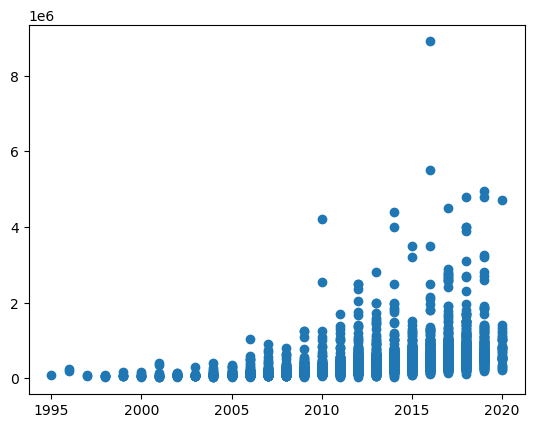

In [275]:
plt.scatter(train['year'], train['selling_price'])
plt.show()

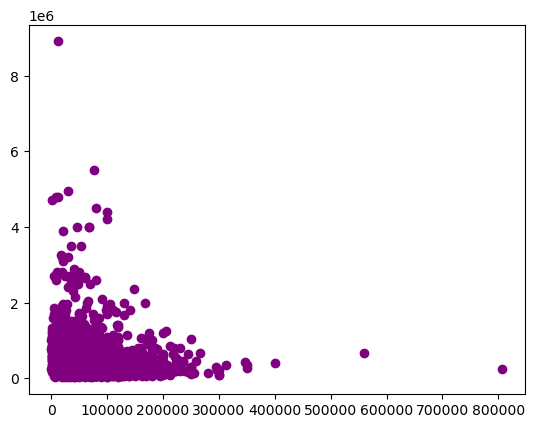

In [265]:
plt.scatter(train['km_driven'], train['selling_price'], color="purple")
plt.show()

We observe some observations which appear to be outliers, since they are isolated. These are the observations where the `km_driven` is very high and the `selling_price` is very low, and the observations where the `km_driven` is very low and the `selling_price` is very high. 

Since they do not follow the pattern of the majority of the observations, these observations may skew the prediction of `selling_price`. So, we decide to apply LOF to these two features to further investigate the potential outliers.

According to the scikit-learn LOF outlier detection example, taking `n_neighbors = 20` works well in general, so we use the default of 20.

**References:**<br>
LOF: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html <br>
Outlier detection with LOF: https://scikit-learn.org/stable/auto_examples/neighbors/plot_lof_outlier_detection.html <br>
Outlier detection with LOF: https://medium.com/@ilyurek/anomaly-detection-with-local-outlier-factor-lof-b1b82227c15e

In [271]:
# Create a copy of the dataset to include the outlier analysis
train_outlier_anal = train.copy()
# Initialize the model
lof = LocalOutlierFactor()
# Predict whether every value is an outlier or not using the model
km_driven_pred = lof.fit_predict(train_outlier_anal[['km_driven', 'selling_price']])
# Store the negative LOF scores (the higher, the more normal)
train_outlier_anal['LOF_Score'] = lof.negative_outlier_factor_
# Store the outlier prediction (-1 represents an outlier and +1 represents an inlier)
train_outlier_anal['Outlier'] = km_driven_pred
# Store the outliers and inliers, and display a few outliers
outliers = train_outlier_anal[train_outlier_anal['Outlier'] == -1].copy()
inliers = train_outlier_anal[train_outlier_anal['Outlier'] == 1].copy()
outliers.head()

,year,selling_price,km_driven,fuel_Diesel,fuel_Electric,fuel_LPG,fuel_Petrol,seller_type_Individual,transmission_Manual,owner_Fourth & Above Owner,owner_Second Owner,owner_Test Drive Car,owner_Third Owner,LOF_Score,Outlier
3050,2020,310000,1700,0,0,0,1,1,1,0,0,0,0,-1.838682,-1
731,2018,4000000,68000,1,0,0,0,1,0,0,0,0,0,-1.994442,-1
1414,2011,450000,235000,1,0,0,0,1,0,0,0,0,0,-1.647168,-1
963,2020,4700000,1500,1,0,0,0,1,0,0,0,0,0,-2.241679,-1
1050,2008,80000,200000,0,0,0,1,1,1,0,0,0,0,-1.503459,-1


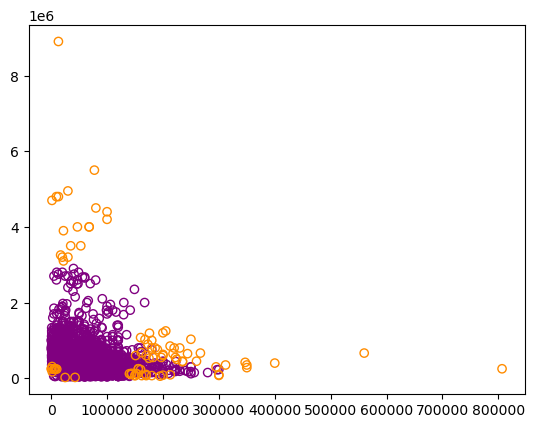

In [272]:
plt.scatter(inliers['km_driven'], inliers['selling_price'], color="none", edgecolors="purple")
plt.scatter(outliers['km_driven'], outliers['selling_price'], color="none", edgecolors="darkorange")
plt.show()

We observe that LOF detected the extreme values as outliers, as well as some observations with low `selling_price` and low `km_driven`.

We attempt to treat the outliers by changing the scale using a log-transformation.

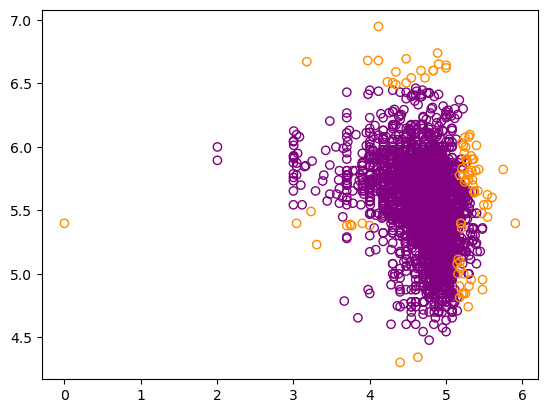

In [273]:
# Apply a log-transformation to both features
outliers['log_selling_price'] = np.log10(outliers['selling_price'])
outliers['log_km_driven'] = np.log10(outliers['km_driven'])
inliers['log_selling_price'] = np.log10(inliers['selling_price'])
inliers['log_km_driven'] = np.log10(inliers['km_driven'])

# Plot the log-transformed features
plt.scatter(inliers['log_km_driven'], inliers['log_selling_price'], color="none", edgecolors="purple")
plt.scatter(outliers['log_km_driven'], outliers['log_selling_price'], color="none", edgecolors="darkorange")
plt.show()

We observe that on a log-scale, the outlying observations appear to follow the pattern of the rest of the points more closely (aside from one observation).

### (d) Predictive analysis: Linear regression

We explore the `LinearRegression` method in scikit-learn. As expected, it minimizes the residual sum of squares between the predicted values and the actual values of the target in order to obtain the coefficients of a linear model. Note that all the default parameters are suitable for our situation. It has an attribute `coef_` which provides the estimated coefficients of the linear model. In order to fit the model, we must run `fit` on the instance of `LinearRegression`, and pass in the training data and the target values. We run `predict` on the instance of `LinearRegression` to obtain the predictions for our target feature.

**References:**<br>
Linear regression: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html <br>

### (e) Feature engineering

We construct two additional features.

The first is created using aggregation and ratios; we compute the ration between the number of kilometers driven by a car and the average number of kilometers driven by cars from that year. Our intuition behind this feature is that in recent years, people upgrade to new cars more frequently than in the past, so it is possible that older cars were designed to last greater wear and tear. So, an older car could have a higher number of kilometers driven but be in similar shape as a newer car with a lower number of kilometers driven, due to their design. Thus, we create a feature that compares a car's kilometers driven to the average number of kilometers driven in that year, where a value greater than 1 suggests that the car is in worse shape than average (has traversed more kilometers) and a value less than 1 suggests that the car is in better shape than average (has traversed less kilometers). Thus, this could provide context on the selling price of the car.

The second feature is created using time differences; we compute the difference between the year which the car is being sold (the present) and the year of the car to determine its age. Newer cars may be more attractive to buyers, leading to a higher price than older cars. Based on the Kaggle description of the dataset, the temporal coverage end date of the dataset is 06/26/2020, so we consider the "present" year to be 2020.

**References:**<br>
Grouping data: https://realpython.com/pandas-groupby/

In [214]:
# Create a copy of the dataset to include the engineered features
train_feature_eng = train.copy()
# Create a Series indexed by the year containing the average km driven for that year
km_driven_by_year = train_feature_eng.groupby("year")["km_driven"].mean()
# Output the values for the most recent five years
km_driven_by_year.tail()

year
2016    57446.342342
2017    41977.967153
2018    28408.074380
2019    19941.947368
2020     8987.800000
Name: km_driven, dtype: float64

In [215]:
# Create a new feature which represents the ratio between the km driven and the mean km driven for cars from the same year
train_feature_eng['km_driven_ratio'] = train_feature_eng['km_driven'] / train_feature_eng['year'].apply(lambda x: km_driven_by_year.loc[x])
# Output a few sample rows
train_feature_eng[['year', 'km_driven', 'km_driven_ratio']].head()

,year,km_driven,km_driven_ratio
3960,2013,88000,1.168428
1982,2019,15000,0.752183
938,2010,87620,0.924955
2039,2017,44000,1.048169
870,2013,80000,1.062207


In [216]:
# Create a new feature which represents the age of the car
train_feature_eng['age'] = 2020 - train_feature_eng['year']
# Output a few sample rows
train_feature_eng[['year', 'age']].head()

,year,age
3960,2013,7
1982,2019,1
938,2010,10
2039,2017,3
870,2013,7


### (f) Empirical study

**References:**<br>
Linear regression: https://www.geeksforgeeks.org/python-linear-regression-using-sklearn/ <br>
Cross validation: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html <br>
Scoring with MSE: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
isin method: https://www.w3schools.com/python/pandas/ref_df_isin.asp <br>

In [217]:
def linear_regression(X_train, y_train):
    # Create the linear regression model
    reg = LinearRegression()

    # Train the model and calculate evaluation metrics using cross validation on the training set
    scoring_metrics = ['r2', 'neg_mean_squared_error']
    scores = cross_validate(reg, X_train, y_train, scoring=scoring_metrics, cv=4)

    # Print R^2 scores from the cross validation
    R_squared_scores = scores['test_r2']
    print("R^2 Scores:", R_squared_scores)
    print(f"Mean: {R_squared_scores.mean():.2f}")
    print(f"Standard deviation: {R_squared_scores.std():.2f}")

    # Print MSE scores from the cross validation
    MSE_scores = scores['test_neg_mean_squared_error']
    print("\nMSE Scores:", MSE_scores)
    print(f"Mean: {MSE_scores.mean():.2f}")
    print(f"Standard deviation: {MSE_scores.std():.2f}")

In [218]:
# Default method (no encoding, no feature engineering)

# Select all the features that will be used to train the model
X_train_default = train.loc[:, ~train.columns.isin(['selling_price'])]
# Select the target feature
y_train_default = train['selling_price']
# Run the linear regression
linear_regression(X_train_default, y_train_default)

R^2 Scores: [0.36653681 0.4548715  0.50614329 0.45015784]
Mean: 0.44
Standard deviation: 0.05

MSE Scores: [-2.10600627e+11 -1.42890369e+11 -9.84487209e+10 -1.26816709e+11]
Mean: -144689106523.53
Standard deviation: 41246696397.08


In [219]:
# Using feature engineering but not outlier analysis

# Select all the features that will be used to train the model
X_train_feature_eng = train_feature_eng.loc[:, ~train_feature_eng.columns.isin(['selling_price'])]
# Select the target feature
y_train_feature_eng = train_feature_eng['selling_price']
# Run the linear regression
linear_regression(X_train_feature_eng, y_train_feature_eng)

R^2 Scores: [0.36753964 0.45781728 0.50363736 0.45318809]
Mean: 0.45
Standard deviation: 0.05

MSE Scores: [-2.10267229e+11 -1.42118214e+11 -9.89482705e+10 -1.26117806e+11]
Mean: -144362879636.04
Standard deviation: 41060294661.12


## Conclusion

## References